##### import libs

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from copy import deepcopy
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

from utils import load_data, evaluate, plot_feature_importances, train_test_split_wise

In [14]:
from feature_processor import compute_lag

##### load data

In [2]:
user_item_data, user_meta_data, item_meta_data, test_pairs_data = load_data()

In [3]:
user_item_data_w_group_features = pd.read_parquet("data/user_item_data_w_group_features.parquet")
test_pairs_data_w_group_features = pd.read_parquet("data/test_pairs_data_w_group_features.parquet")

In [4]:
columns = list(set(user_item_data_w_group_features.columns.to_list()) - set([
    'bookmarks',
    'dislike',
    'explicit',
    'like',
    'share',
    'timespent',
]))

In [5]:
set(test_pairs_data_w_group_features.columns) == set(columns)

True

In [6]:
target = "like"

In [7]:
train_df, val_df = train_test_split(
    user_item_data_w_group_features[columns+[target]],
    test_size=0.15,
    random_state=42,
    shuffle=False,
)

In [9]:
train_df, val_df = compute_lag(
    train_df=train_df,
    val_df=val_df,
    group_col="item_id",
    target_col="like",
    lag=1
)

##### catboost

In [10]:
model = CatBoostClassifier(
    verbose=True,
    iterations=100,
    auto_class_weights="SqrtBalanced",
    # cat_features=["user_id", "source_id", "item_id"]
)

In [11]:
model.fit(train_df[-int(10e6):][columns+["like_lag_1"]],
          train_df[-int(10e6):][target])

Learning rate set to 0.5
0:	learn: 0.3298500	total: 683ms	remaining: 1m 7s
1:	learn: 0.2776674	total: 1.28s	remaining: 1m 2s
2:	learn: 0.2719593	total: 1.81s	remaining: 58.7s
3:	learn: 0.2680953	total: 2.45s	remaining: 58.8s
4:	learn: 0.2652850	total: 3.08s	remaining: 58.6s
5:	learn: 0.2644871	total: 3.66s	remaining: 57.3s
6:	learn: 0.2631431	total: 4.31s	remaining: 57.2s
7:	learn: 0.2628499	total: 4.85s	remaining: 55.8s
8:	learn: 0.2626545	total: 5.36s	remaining: 54.2s
9:	learn: 0.2625090	total: 5.88s	remaining: 53s
10:	learn: 0.2624133	total: 6.39s	remaining: 51.7s
11:	learn: 0.2622472	total: 7s	remaining: 51.4s
12:	learn: 0.2621496	total: 7.49s	remaining: 50.1s
13:	learn: 0.2619984	total: 8.01s	remaining: 49.2s
14:	learn: 0.2618377	total: 8.56s	remaining: 48.5s
15:	learn: 0.2610933	total: 9.2s	remaining: 48.3s
16:	learn: 0.2610215	total: 9.79s	remaining: 47.8s
17:	learn: 0.2609556	total: 10.4s	remaining: 47.3s
18:	learn: 0.2609031	total: 11s	remaining: 46.9s
19:	learn: 0.2607761	tot

In [12]:
model.classes_

array([0, 1])

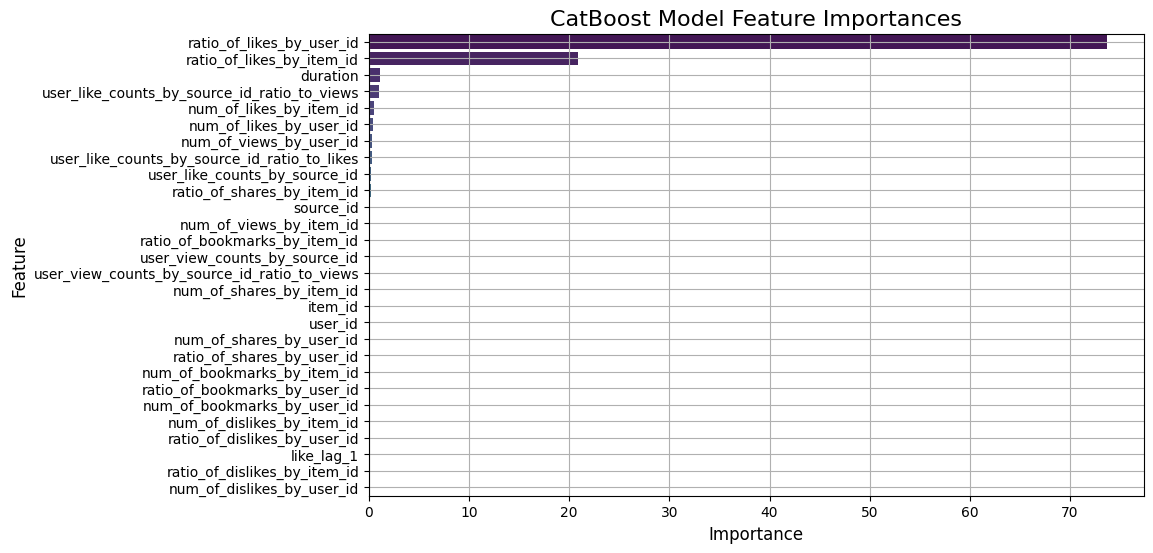

In [13]:
plot_feature_importances(model, graphic=True)

In [15]:
catboost_proba = model.predict_proba(val_df[columns])

CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:72: Feature like_lag_1 is present in model but not in pool.

In [ ]:
evaluate(val_df.user_id.values,
         val_df[target].values,
         catboost_proba[:,1])

100%|██████████| 181721/181721 [00:49<00:00, 3649.03it/s]


0.7905575389502159

### submission

In [12]:
train_df, val_df = compute_lag(
    train_df=user_item_data_w_group_features,
    val_df=test_pairs_data_w_group_features,
    group_col="user_id",
    target_col="like",
    lag=1
)

In [22]:
model = CatBoostClassifier(
    verbose=False,
    iterations=100,
    auto_class_weights="SqrtBalanced",
    # cat_features=["user_id", "source_id", "item_id"]
)

In [23]:
model.fit(user_item_data_w_group_features[-int(10e6):][columns],
          user_item_data_w_group_features[-int(10e6):][target])

In [ ]:
model.fit(train_df[-int(10e6):][columns+["like_lag_1"]],
          train_df[-int(10e6):][target])

In [20]:
test_proba = model.predict_proba(val_df[columns+["like_lag_1"]])

In [24]:
test_proba = model.predict_proba(test_pairs_data_w_group_features[columns])

In [25]:
test_pairs_data["predict"] = test_proba[:,1]
test_pairs_data.to_csv("./cbc_group_fs_lfm_als_submission.csv", index=False)